In [35]:
import kagglehub

path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [36]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [37]:
def load_images(image_paths, size=(224, 224)):
    images = []
    labels = []
    
    for path, label in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, size)
        img = img_to_array(img)
        images.append(img)
        labels.append(label)
        
    images = np.array(images, dtype="float32")
    labels = np.array(labels)
    
    images = preprocess_input(images)
    
    return images, labels


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

batch_size = 64
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2  # Set aside a validation subset
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), 
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

print(train_dir)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train


Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.8339 - loss: 0.4209 - val_accuracy: 0.9146 - val_loss: 0.2147
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 237s 791ms/step - accuracy: 0.9268 - loss: 0.1845 - val_accuracy: 0.9388 - val_loss: 0.1373
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.9349 - loss: 0.1635 - val_accuracy: 0.9369 - val_loss: 0.1658
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 232s 776ms/step - accuracy: 0.9420 - loss: 0.1488 - val_accuracy: 0.9087 - val_loss: 0.2102
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 256s 857ms/step - accuracy: 0.9457 - loss: 0.1455 - val_accuracy: 0.9445 - val_loss: 0.1429
300/300 ━━━━━━━━━━━━━━━━━━━━ 217s 724ms/step - accuracy: 0.9480 - loss: 0.1368
Test Accuracy: 94.62%


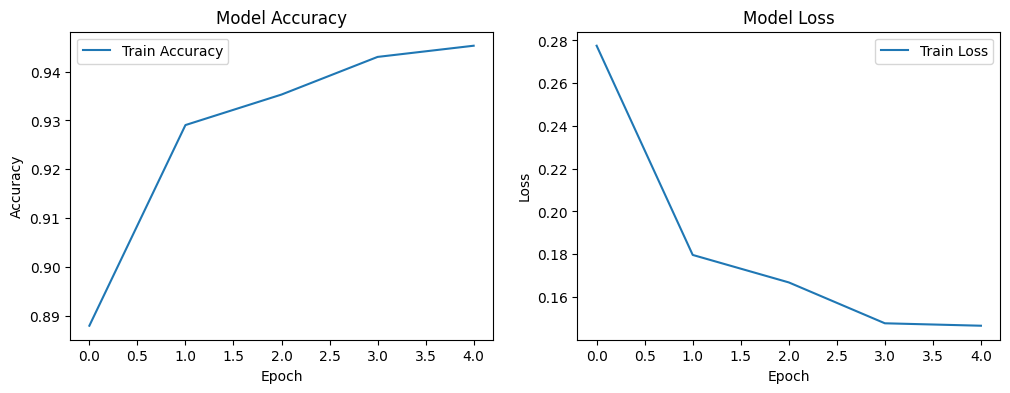

In [39]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-50]:  # Freeze all but last 50 layers
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

steps_per_epoch = 300
validation_steps = 300

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=5
)

test_loss, test_acc = model.evaluate(validation_generator, steps=validation_steps)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [82]:
y_true = validation_generator.classes  # Ground truth labels (0 for REAL, 1 for FAKE)

# Get predicted probabilities
y_pred_probs = model.predict(validation_generator)

# Convert probabilities to binary predictions
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # 0 for REAL, 1 for FAKE

# Compute classification report
report = classification_report(y_true, y_pred, target_names=["REAL", "FAKE"])
print("\nClassification Report:\n", report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 244s 767ms/step

Classification Report:
               precision    recall  f1-score   support

        REAL       0.94      0.95      0.95     10000
        FAKE       0.95      0.94      0.95     10000

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



In [41]:
model.save("/kaggle/working/ai_image_detector.h5")

In [63]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained model
model_path = "/kaggle/working/ai_image_detector.h5"  # Update with actual model path
model = load_model(model_path)

def load_and_preprocess_image(image_path, target_size=(224, 224)):  # Fixed size
    """Load and preprocess a single image."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading {image_path}")
        return None
    img = cv2.resize(img, target_size)
    img = img_to_array(img)
    img = preprocess_input(img)
    return np.expand_dims(img, axis=0)

def predict_images(test_dir):
    """Predicts whether images in test_dir are real or fake."""
    predictions = {}
    
    if not os.path.exists(test_dir):
        print(f"Test directory not found: {test_dir}")
        return predictions

    for category in ['real', 'fake']:
        category_path = os.path.join(test_dir, category)
        if not os.path.exists(category_path):
            print(f"Skipping missing folder: {category_path}")
            continue

        for img_name in os.listdir(category_path):
            if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Only process images
                continue
            
            img_path = os.path.join(category_path, img_name)
            img = load_and_preprocess_image(img_path)
            if img is None:
                continue  # Skip if image couldn't be loaded
            
            pred = model.predict(img)[0][0]  # Get the prediction score
            label = "real" if pred < 0.5 else "fake"  # Threshold at 0.5
            predictions[img_name] = label

    return predictions

# Example usage
test_dir = "/kaggle/input/real-test/Test datasets/Test_dataset_1"  # Update with actual test directory
y_pred = predict_images(test_dir)
print(y_pred)


Skipping missing folder: /kaggle/input/real-test/Test datasets/Test_dataset_1/real
Skipping missing folder: /kaggle/input/real-test/Test datasets/Test_dataset_1/fake
{}


In [72]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load an image and preprocess it
img_path = "/kaggle/input/real-test/Test datasets/Test_dataset_2/4.png"  # Replace with actual path
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict
prediction = model.predict(img_array)
print("Prediction:", "REAL" if prediction[0][0] > 0.5 else "FAKE")
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction: REAL
[[0.8805707]]


In [73]:
for i in images:
    img_path = "/kaggle/input/real-test/Test datasets/Test_dataset_2/"  # Replace with actual path
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    print("Prediction:", "REAL" if prediction[0][0] > 0.5 else "FAKE")
    print(prediction)

11.png
4.png
9.png
14.png
1.png
20.png
2.png
10.png
18.png
12.png
7.png
17.png
5.png
3.png
16.png
8.png
6.png
15.png
13.png
19.png


In [69]:
import os

# Check FAKE images in the test dataset
images = os.listdir("/kaggle/input/real-test/Test datasets/Test_dataset_1")

# Check REAL images in the test dataset
real_images = os.listdir("/kaggle/input/real-test/Test datasets/Test_dataset_2")

print("Fake Images Sample:", images[:])  # Show first 5 fake images
print("rImages Sample:", real_images[:]) # Show first 5 real images

Fake Images Sample: ['11.png', '4.png', '9.png', '14.png', '1.png', '20.png', '2.png', '10.png', '18.png', '12.png', '7.png', '17.png', '5.png', '3.png', '16.png', '8.png', '6.png', '15.png', '13.png', '19.png']
rImages Sample: ['11.png', '4.png', '9.png', '14.png', '1.png', '20.png', '2.png', '10.png', '18.png', '12.png', '7.png', '17.png', '5.png', '3.png', '16.png', '8.png', '6.png', '15.png', '13.png', '19.png']


In [77]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the trained model
model_path = "/kaggle/working/ai_image_detector.h5"  # Update with actual model path
model = load_model(model_path)

# Path to test images
test_dir = "/kaggle/input/real-test/Test datasets/Test_dataset_2/"  # Update path

# Store predictions
predictions_list = []

# Get all image files in the test dataset
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for img_name in image_files:
    img_path = os.path.join(test_dir, img_name)
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # Match model input size
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)[0][0]
    label = "REAL" if prediction < 0.5 else "FAKE"  # Adjust threshold if needed
    
    # Append results
    predictions_list.append([img_name, label])

# Convert predictions to a DataFrame
df = pd.DataFrame(predictions_list, columns=["Image", "Prediction"])

# Save to CSV
csv_path = "/kaggle/working/predictions_1.csv"
df.to_csv(csv_path, index=False)

print(f"Predictions saved to {csv_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predictions saved to /kaggle/working/predictions_1.csv


In [78]:
model_path = "/kaggle/working/ai_image_detector.h5"  # Update with actual model path
model = load_model(model_path)

# Path to test images
test_dir = "/kaggle/input/real-test/Test datasets/Test_dataset_1/"  # Update path

# Store predictions
predictions_list = []

# Get all image files in the test dataset
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

for img_name in image_files:
    img_path = os.path.join(test_dir, img_name)
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # Match model input size
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)[0][0]
    label = "REAL" if prediction < 0.5 else "FAKE"  # Adjust threshold if needed

    # Append results
    predictions_list.append([img_name, label])

# Convert predictions to a DataFrame
df = pd.DataFrame(predictions_list, columns=["Image", "Prediction"])

# Save to CSV
csv_path = "/kaggle/working/predictions_2.csv"
df.to_csv(csv_path, index=False)

print(f"Predictions saved to {csv_path}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predictions saved to /kaggle/working/predictions_2.csv


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score



# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.5049
Recall:    0.4919
F1 Score:  0.4983


In [80]:
from sklearn.metrics import classification_report, accuracy_score

# Load the trained model
model_path = "/kaggle/working/ai_image_detector.h5"  # Update with actual model path
model = load_model(model_path)

# Define test dataset path
test_dir = "/kaggle/input/real-test/Test datasets/Test_dataset_2/"  # Update path

# Lists to store actual labels and predicted labels
y_true = []  # Actual labels (0 for REAL, 1 for FAKE)
y_pred = []  # Predicted labels

# Define actual labels based on folder names
class_mapping = {"real": 0, "fake": 1}  # Assigning 0 to real and 1 to fake

for category in ["real", "fake"]:
    category_path = os.path.join(test_dir, category)
    if not os.path.exists(category_path):
        print(f"Skipping missing folder: {category_path}")
        continue

    for img_name in os.listdir(category_path):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue  # Skip non-image files

        img_path = os.path.join(category_path, img_name)

        # Load and preprocess image
        img = image.load_img(img_path, target_size=(224, 224))  # Match model input size
        img_array = image.img_to_array(img) / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict
        prediction = model.predict(img_array)[0][0]  # Probability score
        predicted_label = 1 if prediction > 0.5 else 0  # Convert to 0 or 1

        # Store actual and predicted labels
        y_true.append(class_mapping[category])  # 0 for real, 1 for fake
        y_pred.append(predicted_label)

# Compute precision, recall, and F1-score
report = classification_report(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print("Classification Report:\n", report)
print("Accuracy:", accuracy)

Skipping missing folder: /kaggle/input/real-test/Test datasets/Test_dataset_2/real
Skipping missing folder: /kaggle/input/real-test/Test datasets/Test_dataset_2/fake


ValueError: max() arg is an empty sequence